## Alzheimer

In [20]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from sklearn.metrics import auc, roc_auc_score, accuracy_score, confusion_matrix,recall_score
from xgboost import XGBClassifier
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
sys.path.append(os.path.relpath('../src'))
import utils as ut



## Data reading and preliminary analysis

In [3]:
### Origin: https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset
alz = pd.read_csv('../data/class/raw/alzheimers_disease_data.csv',index_col='PatientID')
alz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2149 entries, 4751 to 6899
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64  

In [4]:
alz.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
PatientID,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


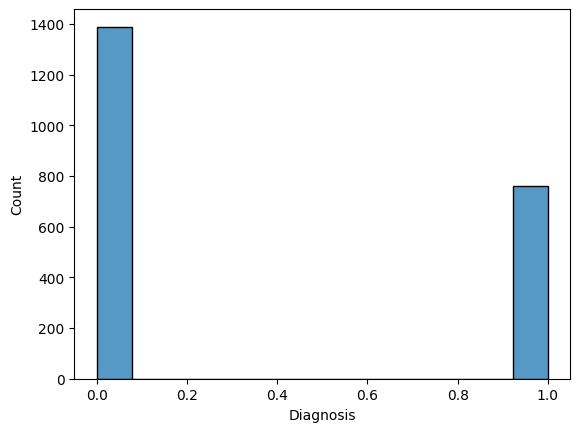

In [5]:
sns.histplot(alz['Diagnosis']);

<Axes: >

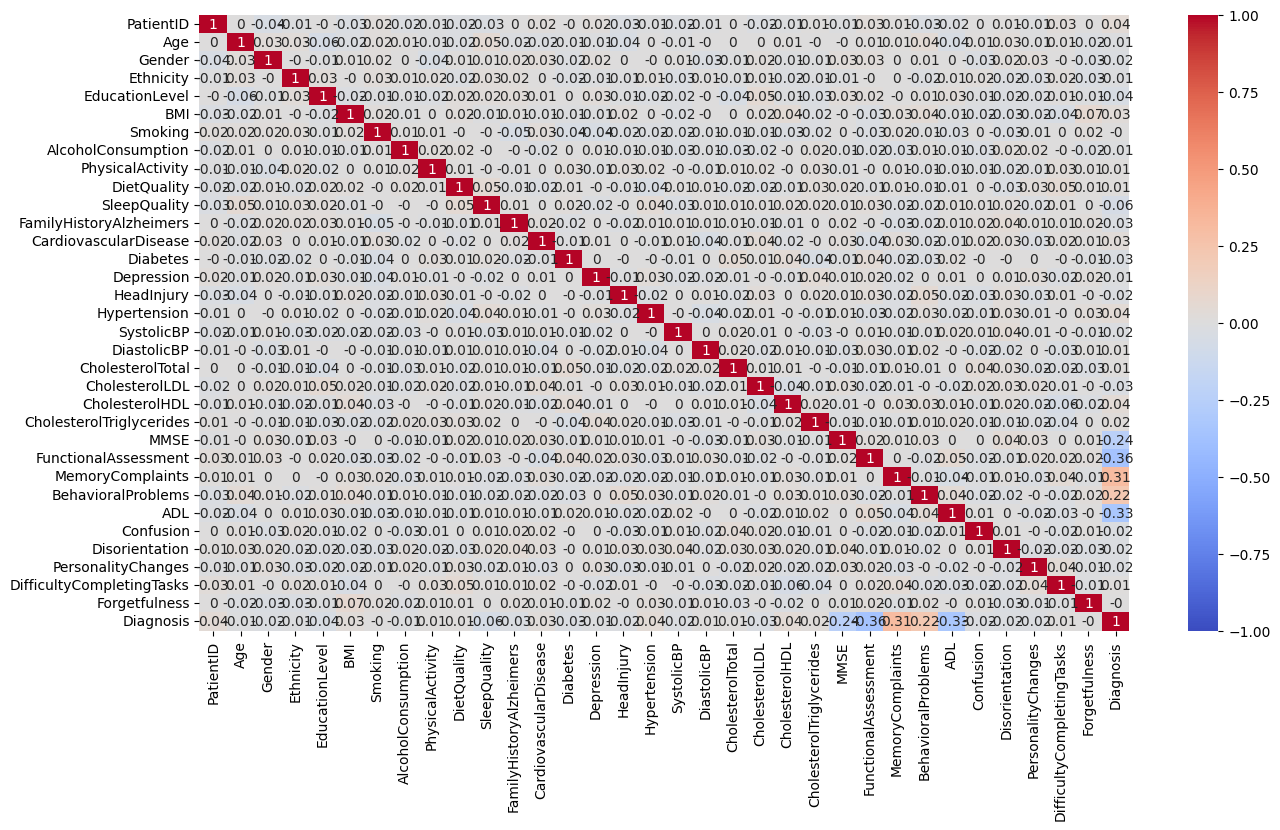

In [ ]:
alz_num = alz.select_dtypes(include=['int','float'])
plt.figure(figsize=(15,8))
sns.heatmap(round(alz_num.corr(),2), vmin=-1,annot=True,cmap='coolwarm')


In [6]:
### Datasets divided by category
alz_dem = alz[['Age','Gender','Ethnicity','EducationLevel','Diagnosis']]
alz_lif = alz[['BMI','Smoking','AlcoholConsumption','PhysicalActivity','DietQuality','SleepQuality','Diagnosis']]
alz_med = alz[['FamilyHistoryAlzheimers','CardiovascularDisease','Diabetes','Depression','HeadInjury','Hypertension','Diagnosis']]
alz_cli = alz[['SystolicBP','DiastolicBP','CholesterolTotal','CholesterolLDL','CholesterolHDL','CholesterolTriglycerides','Diagnosis']]
alz_cog = alz[['MMSE','FunctionalAssessment','MemoryComplaints','BehavioralProblems','ADL','Diagnosis']]
alz_sym = alz[['Confusion','Disorientation','PersonalityChanges','DifficultyCompletingTasks','Forgetfulness','Diagnosis']]

In [19]:
### Useful new variables
alz['Elder'] = np.where(alz['Age']<alz['Age'].mean(),1,0)


<Axes: >

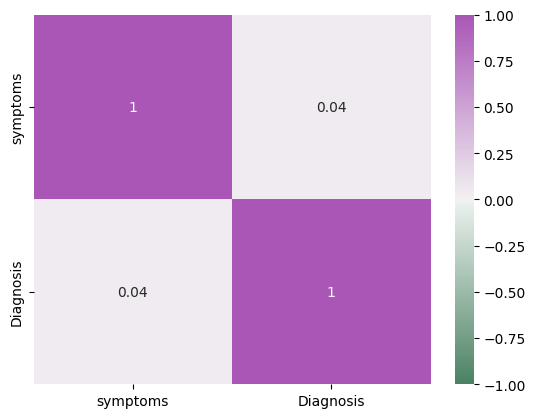

In [30]:
palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(round(alz[['symptoms','Diagnosis']].corr(),2), vmin=-1,annot=True, cmap=palette)

In [29]:
### Aggregated variables
alz['medical_conditions']= -alz['FamilyHistoryAlzheimers'] + alz['CardiovascularDisease']-alz['Diabetes']-alz['Depression']-alz['HeadInjury']+alz['Hypertension']
alz['demographics'] = alz['Elder'] + alz['Gender'] + alz['Ethnicity'] + alz['EducationLevel']
alz['clinical'] = -alz['SystolicBP'] + alz['DiastolicBP'] + alz['CholesterolTotal'] - alz['CholesterolLDL'] -alz['CholesterolLDL'] +alz['CholesterolHDL'] +alz['CholesterolTriglycerides']
alz['symptoms'] = -alz['Confusion'] - alz['Disorientation'] - alz['PersonalityChanges'] + alz['DifficultyCompletingTasks']

<Axes: >

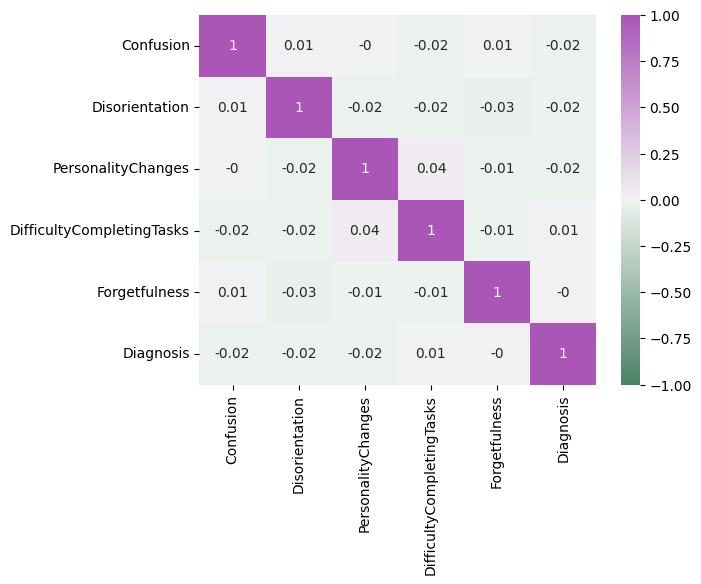

In [27]:
palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(round(alz_sym.corr(),2), vmin=-1,annot=True, cmap=palette)


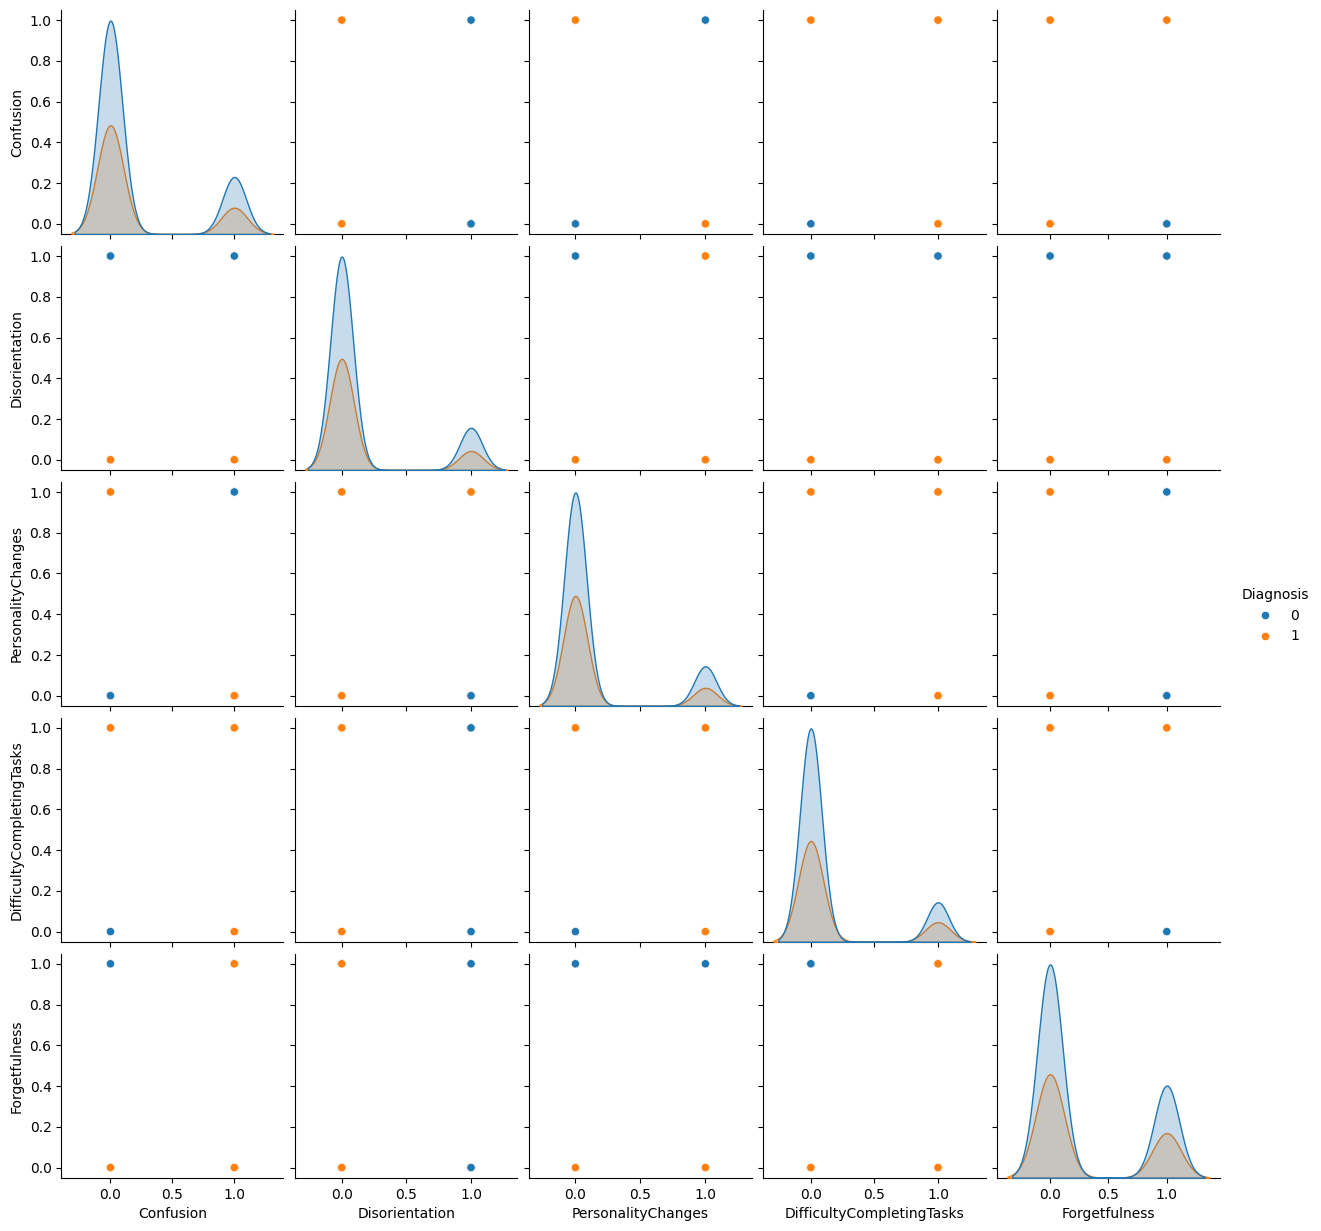

In [15]:
sns.pairplot(data=alz_sym,hue='Diagnosis')

Further investigation shows no further option of a better model inducing feature engeneering

## Model #2

This second model has three priorities over the baseline model:
- A broader selection of input variables, which will be reduced further with PCA.
- A priorization on recall over other measures (we want to make sure we get all the positives, even if we get more false positives in the way).
- A hyperparametrization, to get the best possible result

### Variable selection and PCA

Variables with over 0.05 correlation with the target are selected. If any combination of variables reach that number, it is also included.

In [21]:
### Origin: https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset
alz = pd.read_csv('../data/class/raw/alzheimers_disease_data.csv',index_col='PatientID')
alz = ut.feat_eng(alz)

In [22]:
alz_2 = alz[['medical_conditions','demographics','clinical','symptoms','MMSE','FunctionalAssessment',
             'MemoryComplaints','BehavioralProblems','ADL','Diagnosis']]

<Axes: >

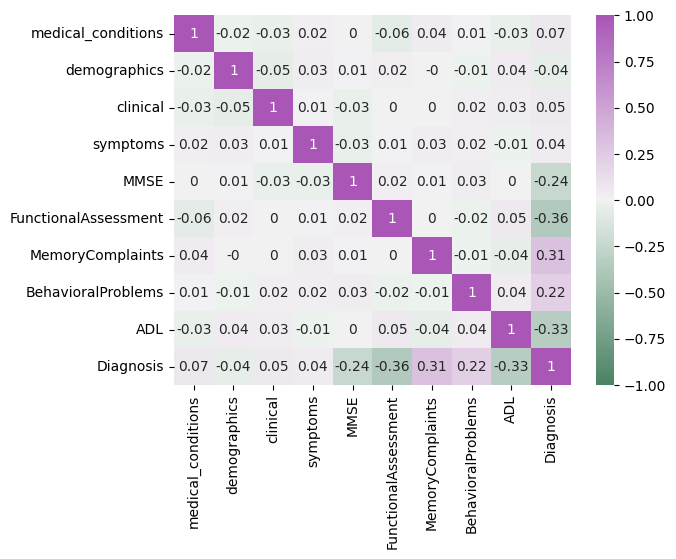

In [6]:
palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(round(alz_2.corr(),2), vmin=-1,annot=True, cmap=palette)

9 variables for the second model. First Scalling, then PCA

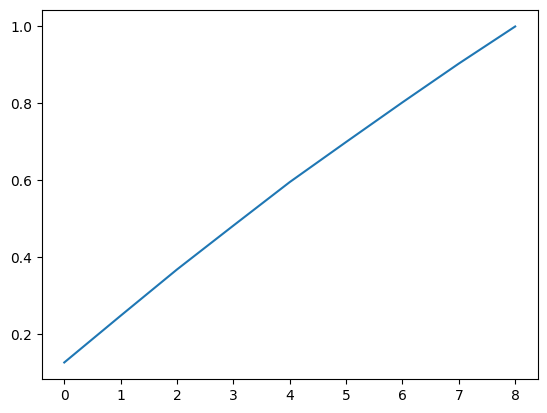

In [42]:
x1_train, x1_test, y1_train, y1_test = ut.train_test(alz_2,test_size=.2)
scaler = StandardScaler()
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)
pca = PCA(n_components=9)
x1_train = pca.fit_transform(x1_train)
pca_acum = pca.explained_variance_ratio_.cumsum()
sns.lineplot(data=pca_acum);

PCA doesn't seem very useful, so we return to the original variables

In [23]:
x1_train, x1_test, y1_train, y1_test = ut.train_test(alz_2,test_size=.2)


In [15]:
print(x1_train.shape)
print(x1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(1719, 9)
(430, 9)
(1719,)
(430,)


### Hyperparametrization

In [ ]:
### Second model
np.random.seed(42)
pipe = Pipeline(steps=[('scaler', None),
                       ('feature_selection', SelectKBest()),
                       ('classifier', svm.SVC())
                       ])
xgb_param = {
    'classifier': [XGBClassifier(n_estimators = 100)],
    'classifier__n_estimators': [20,50,100,250],
    'classifier__eta': [0.001, 0.1, 0.5,0.8],
    'classifier__max_depth': [3,5,7,9,12,15]
}
knn_param = {
    'scaler':[StandardScaler()],
    'classifier': [KNeighborsClassifier()],
}
grb_param = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__max_depth': [2,4,7],
    'classifier__min_samples_split': [2,5,10]
    # 'classifier_max_depth':
    # 'classifier_max_depth':
}
svm_param = {
    'classifier': [svm.SVC()],
    'classifier__C': [0.1, 0.5, 1, 5, 10],
}
log_param = {
    'classifier': [LogisticRegression(max_iter=1000, solver='liblinear'), LogisticRegression(max_iter=10, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}
rfor_param = {
    # 'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [2,3]
}

ada_param = {
    'classifier': [AdaBoostClassifier()],
    'classifier__n_estimators': [20,50,100]
}
search_space = [
    knn_param,
    xgb_param,
    ada_param,
    rfor_param,
    grb_param,
    log_param,
    svm_param
]
gs= GridSearchCV(estimator = pipe, param_grid=search_space,cv=5,verbose=2,scoring='recall',n_jobs=-1)
gs.fit(x1_train, y1_train)
y1_pred = gs.best_estimator_.predict(x1_test)
gswin = gs.best_estimator_
print("Accuracy", accuracy_score(y1_test,y1_pred))
print("AUC", roc_auc_score(y1_test,y1_pred))
print("Recall", recall_score(y1_test,y1_pred))
print(confusion_matrix(y1_test,y1_pred))
print(gs.best_params_)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\raulg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


Accuracy 0.9441860465116279
AUC 0.9344708443771297
Recall 0.9013157894736842
[[269   9]
 [ 15 137]]
{'classifier': GradientBoostingClassifier(), 'classifier__max_depth': 2, 'classifier__min_samples_split': 2}


Less recall than in the baseline model. We go back to the same variables, and check whether it's possible a better output

In [24]:
alz_2b = alz[['MMSE','FunctionalAssessment','MemoryComplaints','BehavioralProblems','ADL','Diagnosis']] #,'mix'
x1_train, x1_test, y1_train, y1_test = ut.train_test(alz_2b,test_size=.2)

In [ ]:
### Second model
### COMP Time: 10 mins
np.random.seed(42)
pipe = Pipeline(steps=[('scaler', None),
                    #    ('feature_selection', SelectKBest()),
                       ('classifier', svm.SVC())
                       ])
xgb_param = {
    'classifier': [XGBClassifier(n_estimators = 100)],
    'classifier__n_estimators': [20,50,100,250],
    'classifier__eta': [0.001, 0.1, 0.5,0.8],
    'classifier__max_depth': [3,5,7,9,12,15]
}
knn_param = {
    'scaler':[StandardScaler()],
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__leaf_size':[10, 30, 50]
}
grb_param = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__max_depth': [3,5,7],
    'classifier__min_samples_split': [2,5,10],
    'classifier__learning_rate':[0.01, 0.05, 0.1, 0.2],
    'classifier__n_estimators':[100, 200, 500],
    'classifier__subsample':[0.6, 0.8, 1.0],
    'classifier__max_features': ['sqrt', 'log2', None]
    # 'classifier_max_depth':
    # 'classifier_max_depth':
}
svm_param = {
    'classifier': [svm.SVC()],
    'classifier__C': [0.1, 0.5, 1, 5, 10],
}
log_param = {
    'classifier': [LogisticRegression(max_iter=1000, solver='liblinear'), LogisticRegression(max_iter=10, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
}
rfor_param = {
    # 'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [2,3]
}

ada_param = {
    'classifier': [AdaBoostClassifier()],
    'classifier__n_estimators': [20,50,100]
}
search_space = [
    knn_param,
    xgb_param,
    ada_param,
    rfor_param,
    grb_param,
    log_param,
    svm_param
]
gs= GridSearchCV(estimator = pipe, param_grid=search_space,cv=5,verbose=2,scoring='recall',n_jobs=-1)
gs.fit(x1_train, y1_train)
y1_pred = gs.best_estimator_.predict(x1_test)
gswin = gs.best_estimator_
print("Accuracy", accuracy_score(y1_test,y1_pred))
print("AUC", roc_auc_score(y1_test,y1_pred))
print("Recall", recall_score(y1_test,y1_pred))
print(confusion_matrix(y1_test,y1_pred))
print(gs.best_params_)


Fitting 5 folds for each of 1112 candidates, totalling 5560 fits
Accuracy 0.958139534883721
AUC 0.9482440363498675
Recall 0.9144736842105263
[[273   5]
 [ 13 139]]
{'classifier': GradientBoostingClassifier(), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__max_features': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__subsample': 0.6}


In [28]:
model_2 = gs.best_estimator_
pickle.dump(model_2,open("../models/class/model_2.pkl", "wb"))
